In [2]:
var openDigger = require('../src/open_digger');

### 查看数据库

In [3]:
var query = openDigger.driver.clickhouse.query;
query(    
    `SHOW DATABASES`
).then(
    res=>{  console.log(res); }
)

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


### 查看表

In [7]:
var query = openDigger.driver.clickhouse.query;
query( `SHOW TABLES from github_log `).then(res=>{    console.log(res);})

[ { name: 'events' } ]


In [44]:
// 查看一些数据
var limit = 10;
query(    
    `
    SELECT *
    FROM github_log.events  
    WHERE repo_name = 'facebook/react-native'
    LIMIT ${limit}
    `
)
.then(
    res=>{console.log(res);}
    );

[
  {
    id: '2679760908',
    type: 'CommitCommentEvent',
    action: 'added',
    actor_id: '587518',
    actor_login: 'amasad',
    repo_id: '29028775',
    repo_name: 'facebook/react-native',
    org_id: '69631',
    org_login: 'facebook',
    created_at: '2015-03-26 18:20:07',
    issue_id: '0',
    issue_number: 0,
    issue_title: '',
    body: '@vjeux can you publish a new react-native-cli version?',
    'issue_labels.name': [],
    'issue_labels.color': [],
    'issue_labels.default': [],
    'issue_labels.description': [],
    issue_author_id: '0',
    issue_author_login: '',
    issue_author_type: 'Bot',
    issue_author_association: 'COLLABORATOR',
    issue_assignee_id: '0',
    issue_assignee_login: '',
    'issue_assignees.login': [],
    'issue_assignees.id': [],
    issue_created_at: null,
    issue_updated_at: null,
    issue_comments: 0,
    issue_closed_at: null,
    issue_comment_id: '0',
    issue_comment_created_at: null,
    issue_comment_updated_at: null,
    

### 1. 每月新增star和fork数

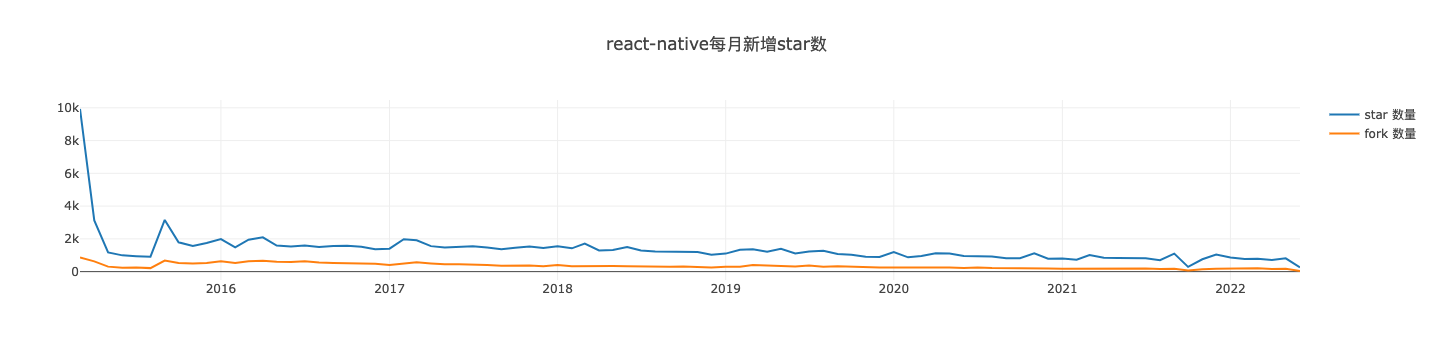

In [54]:
query(
    `
    select formatDateTime(created_at, '%Y-%m') as m, 
    count(case when repo_name = 'facebook/react-native' and type='WatchEvent' then 1 else null end)  as starCnt, 
    count(case when repo_name = 'facebook/react-native' and type='ForkEvent' then 1 else null end) as forkCnt
    from github_log.events
    where repo_name = 'facebook/react-native'
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
    ` 
).then(
    data => {
        // console.log(data)
        openDigger.render.plotly([
        {y: data.map(d => d.starCnt), x: data.map(d => d.m), mode: 'scatter', name: 'star 数量'},
        {y: data.map(d => d.forkCnt), x: data.map(d => d.m), mode: 'scatter', name: 'fork 数量'}
    ],{title: `react-native每月新增star和fork数量`}); 
    }
     
)

### 2. 每月打开和关闭的issue

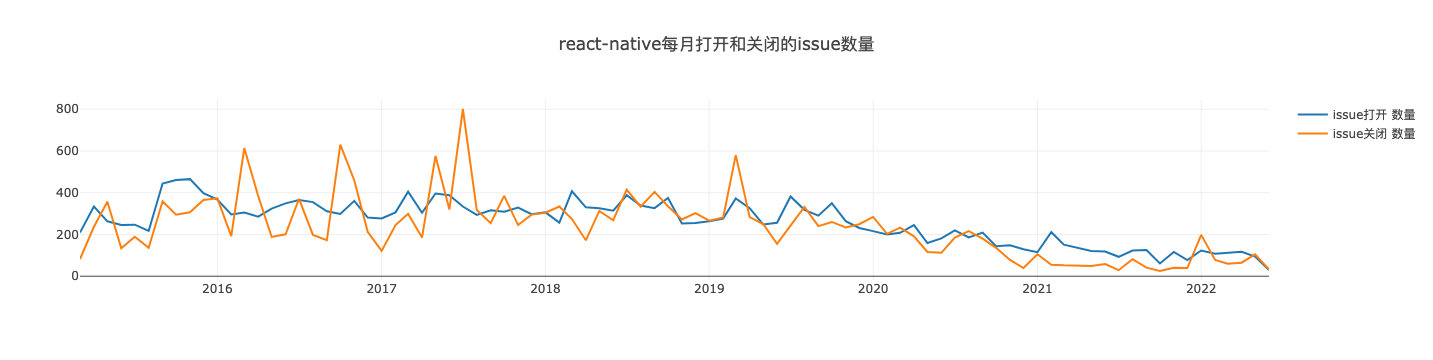

In [57]:
query(
`
    select formatDateTime(created_at, '%Y-%m') as m, 
    count(case when repo_name = 'facebook/react-native' and type='IssuesEvent' and action in ['opened', 'reopened'] then 1 else null end) as openCnt,
    count(case when repo_name = 'facebook/react-native' and type='IssuesEvent' and action='closed' then 1 else null end) as closeCnt
    from github_log.events
    where repo_name = 'facebook/react-native'    
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`
).then(
    data => {
        // console.log(data)
        openDigger.render.plotly([
        {y: data.map(d => d.openCnt), x: data.map(d => d.m), mode: 'scatter', name: 'issue打开 数量'},
        {y: data.map(d => d.closeCnt), x: data.map(d => d.m), mode: 'scatter', name: 'issue关闭 数量'}
    ],{title: `react-native每月打开和关闭的issue数量`}); 
    }
)

### 3. 每月打开PR和合入PR的个数

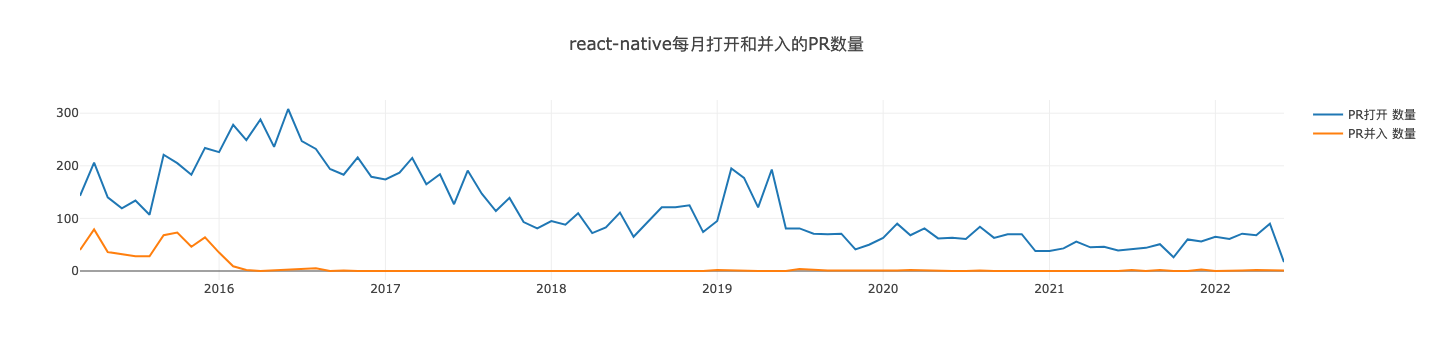

In [61]:
query(
`
    select formatDateTime(created_at, '%Y-%m') as m, 
    count(case when repo_name = 'facebook/react-native' and type='PullRequestEvent' and action= 'opened' then 1 else null end) as openCnt,
    count(case when repo_name = 'facebook/react-native' and type='PullRequestEvent' and pull_merged=1 then 1 else null end) as mergeCnt
    from github_log.events
    where repo_name = 'facebook/react-native'    
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`
).then(
    data => {
        // console.log(data)
        openDigger.render.plotly([
        {y: data.map(d => d.openCnt), x: data.map(d => d.m), mode: 'scatter', name: 'PR打开 数量'},
        {y: data.map(d => d.mergeCnt), x: data.map(d => d.m), mode: 'scatter', name: 'PR并入 数量'}
    ],{title: `react-native每月打开和并入的PR数量`}); 
    }
)

### 4. 每月在仓库中活跃的不同开发者总数

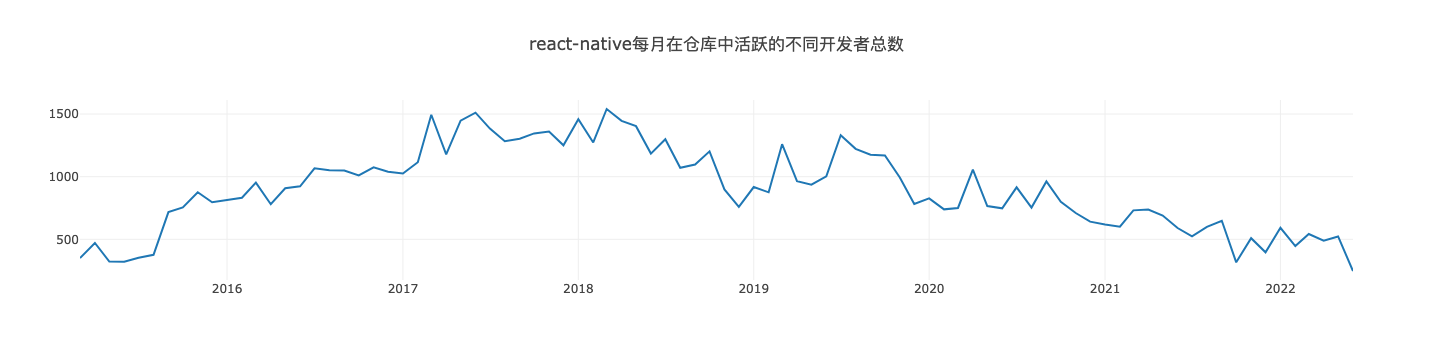

In [63]:
query(
`
    select formatDateTime(created_at, '%Y-%m') as m, count(distinct actor_id) as cnt
    from github_log.events 
    where repo_name = 'facebook/react-native' 
    and type in ['IssueCommentEvent', 'IssuesEvent', 'PullRequestEvent', 'PullRequestReviewCommentEvent']
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`
).then(
    data => {
        // console.log(data)
        openDigger.render.plotly([
        {y: data.map(d => d.cnt), x: data.map(d => d.m), mode: 'scatter', name: '开发者活跃 数量'},
    ],{title: `react-native每月在仓库中活跃的不同开发者总数`}); 
    }
)

### 5. issue从打开到关闭的平均时长和中位数（单位：天）

In [70]:
query(
`
    select 
    avg(round((issue_closed_at - issue_created_at)/(24*60*60), 2)) as avgDuration,
    median(round((issue_closed_at - issue_created_at)/(24*60*60), 2)) as midDuration
    from github_log.events
    where repo_name = 'facebook/react-native'
    and type = 'IssuesEvent'
    and action = 'closed'
`
).then(
    data => {
        console.log("issue从打开到关闭的平均时长: ", data[0].avgDuration, "(天)")
        console.log("issue从打开到关闭时长中位数: ", data[0].midDuration, "(天)")
    }
)

issue从打开到关闭的平均时长:  66.32908424555292 (天)
issue从打开到关闭时长中位数:  7.075 (天)


### 6. PR从打开到合入的平均时长和中位数（单位：天）

In [81]:
query(
`
    select 
    avg(round((issue_closed_at - issue_created_at)/(24*60*60), 2)) as avgDuration,
    median(round((issue_closed_at - issue_created_at)/(24*60*60), 2)) as midDuration
    from github_log.events
    where repo_name = 'facebook/react-native'
     and type = 'PullRequestEvent'
    and pull_merged = 1
`
).then(
    data => {
        console.log("PR从打开到关闭的平均时长: ", data[0].avgDuration, "(天)")
        console.log("PR从打开到关闭时长中位数: ", data[0].midDuration, "(天)")
    }
)

issue从打开到关闭的平均时长:  2.613344481605346 (天)
issue从打开到关闭时长中位数:  0.08499999999999999 (天)


### 7. issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [106]:
query(
`
    select 
    avg(time) as avgTime, 
    median(time) as midTime
    from (
    select min(issue_comment_created_at - issue_created_at)/(24*60*60) as time
    from github_log.events
    where repo_name = 'facebook/react-native'
    and type = 'IssueCommentEvent'
    and issue_comment_id != '0'
    group by issue_id
    )
`
).then(
    data => {
        console.log("issue和PR从打开到第一次有人回复（非本人回复）的平均时长（单位：天: ", data[0].avgTime)
        console.log("issue和PR从打开到第一次有人回复（非本人回复）的中位数（单位：天: ", data[0].midTime)
    }
)

issue和PR从打开到第一次有人回复（非本人回复）的平均时长（单位：天:  11.64617898895426
issue和PR从打开到第一次有人回复（非本人回复）的中位数（单位：天:  0.03490162037037037
